In [ ]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- Text Preprocessing ---

# Download necessary NLTK data
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.word_tokenize('test')
except LookupError:
    nltk.download('punkt')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')

# Load the dataset
df = pd.read_excel('preprocessed_data.xlsx')

# Combine relevant text columns and handle potential missing values
df['text_to_analyze'] = df['Description'].fillna('') + ' ' + df['Suggestions'].fillna('')

# Initialize lemmatizer and stop words
# Original stop words
stop_words = set(stopwords.words('english'))

# --- Add custom, domain-specific stop words ---
domain_specific_stopwords = ['regulation', 'reg', 'coal', 'person', 'required', 'work', 'provision']
stop_words.update(domain_specific_stopwords)

# The rest of your code would follow, using this updated stop_words set
# in your preprocess_text function.

def preprocess_text(text):
    """Cleans and preprocesses a single text string."""
    text = text.lower()  # Lowercase
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = nltk.word_tokenize(text)  # Tokenize
    # Lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['text_to_analyze'].apply(preprocess_text)

# --- Topic Modeling ---

# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.80, min_df=2)
doc_term_matrix = vectorizer.fit_transform(df['processed_text'])

# Apply Latent Dirichlet Allocation (LDA)
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(doc_term_matrix)

# Get topic distributions for each document
topic_distributions = lda.transform(doc_term_matrix)

# --- Assign Topics and Probabilities ---

# Get the dominant topic and its probability for each document
dominant_topic = np.argmax(topic_distributions, axis=1)
probability = np.max(topic_distributions, axis=1)

# Add to the dataframe
df['topic'] = dominant_topic
df['probability'] = probability

# --- Display Keywords for Each Topic ---

def display_topics(model, feature_names, n_top_words):
    """Prints the top keywords for each topic."""
    print("--- Topic Keywords ---")
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx}: "
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print("----------------------")


n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, n_top_words)

# --- Save and Display Final Data ---

# Select and reorder columns for the final output
final_df = df[['Description', 'Suggestions', 'topic', 'probability']]

# Save the final dataframe to a new CSV file
final_df.to_csv('final_data_with_topics.csv', index=False)

print("\n--- Final Data Preview (First 5 Rows) ---")
print(final_df.head())
print("\nSuccessfully created 'final_data_with_topics.csv'")

--- Topic Keywords ---
Topic 0: roof, regulation, person, support, injury, side, height, measuring, fell, gallery
Topic 1: bench, dump, overburden, blasting, crack, form, situ, dumped, deployed, area
Topic 2: regulation, tipper, read, negligently, dumper, person, road, injury, operator, provision
Topic 3: regulation, water, person, working, read, two, area, due, blasting, pump
Topic 4: regulation, dozer, safety, injury, belt, succumbed, conveyor, electric, tub, serious
----------------------

--- Final Data Preview (First 5 Rows) ---
                                         Description  \
0  While a crew of seven support personnel were e...   
1  While a dresser was dressing the side of a gal...   
2  While a dresser was dressing the side of a gal...   
3  While a group of four persons went at a juncti...   
4  While a group of four persons went at a juncti...   

                                         Suggestions  topic  probability  
0  Had, i) the support personnel been no t deplo

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('final_data_with_topics.csv')

# Calculate incident counts for each topic
topic_counts = df['topic'].value_counts()

# Calculate the percentage for each topic
topic_percentages = df['topic'].value_counts(normalize=True) * 100

# Combine into a single summary DataFrame
stats_df = pd.DataFrame({
    'Incident Count': topic_counts,
    'Percentage': topic_percentages.round(1)
})

print("--- Topic Distribution ---")
print(stats_df)

--- Topic Distribution ---
       Incident Count  Percentage
topic                            
2                 166        44.6
4                  78        21.0
0                  65        17.5
3                  39        10.5
1                  24         6.5


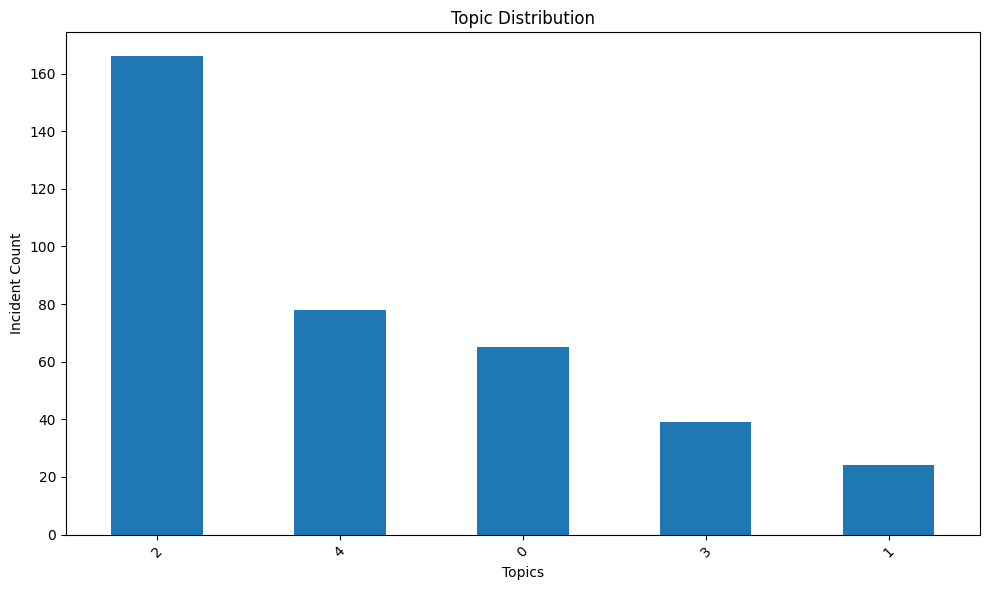

In [ ]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.colab import files

# --- 1. Load Your Original Data and the Topic Results ---

# Load the original Excel file
df_main = pd.read_excel('preprocessed_data.xlsx')

# Load the CSV file containing the topic assignments and probabilities
# This file was created by the previous script
df_topics = pd.read_csv('final_data_with_topics.csv')

# --- 2. Add Topic and Probability Columns to the Main Data ---

# Add the new columns to your original dataframe
# This assumes the rows in both files are in the same order
df_main['topic'] = df_topics['topic']
df_main['probability'] = df_topics['probability']


# --- 3. Create the Topic Interpretation Sheet ---

# Create a dictionary with the topic interpretations
topic_explanation = {
    'Topic Number': [0, 1, 2, 3, 4],
    'Topic Meaning': [
        'Underground Roof & Wall Support',
        'Opencast Mining & Blasting',
        'Vehicle & Dumper Negligence',
        'Water Hazards & General Operations',
        'Machinery & Conveyor Safety'
    ],
    'Interpretation': [
        'Incidents related to the structural integrity of underground mines, specifically roof collapses and side wall failures.',
        'Surface mining operations, including blasting activities and the management of waste rock and benches.',
        'Accidents involving heavy vehicles like tippers and dumpers, with a strong signal toward human error or negligence.',
        'Hazards related to water management (pumps, drainage) and other general dangers in a working area.',
        'Accidents involving both stationary machinery (conveyors) and mobile equipment (dozers).'
    ],
    'Top Keywords': [
        'roof, support, side, height, measuring, fell, gallery',
        'bench, dump, overburden, blasting, crack, form, situ',
        'tipper, negligently, dumper, road, injury, operator',
        'water, working, two, due, blasting, pump',
        'dozer, safety, injury, belt, succumbed, conveyor, electric'
    ]
}

# Create a DataFrame from the dictionary
df_interpretations = pd.DataFrame(topic_explanation)


# --- 4. Write Both DataFrames to a New Excel File with Two Sheets ---

output_filename = 'Final_Report_with_Topics.xlsx'

with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    # Write the main data to the first sheet
    df_main.to_excel(writer, sheet_name='Data_with_Topics', index=False)

    # Write the interpretations to a new sheet
    df_interpretations.to_excel(writer, sheet_name='Topic_Interpretations', index=False)

    # Auto-adjust column widths for readability
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        for idx, col in enumerate(df_main.columns):
             worksheet.set_column(idx, idx, 20) # Set a default width
        if sheet_name == 'Topic_Interpretations':
             worksheet.set_column(1, 1, 30) # Widen the 'Meaning' column
             worksheet.set_column(2, 2, 50) # Widen the 'Interpretation' column
             worksheet.set_column(3, 3, 50) # Widen the 'Keywords' column


print(f"Successfully created '{output_filename}' with two sheets.")

# --- 5. Trigger the Download ---
files.download(output_filename)

Successfully created 'Final_Report_with_Topics.xlsx' with two sheets.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# First, ensure necessary libraries are installed
try:
    import xlsxwriter
except ImportError:
    print("Installing xlsxwriter...")
    !pip install xlsxwriter -q

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from google.colab import files

# --- 1. Text Preparation ---

# Load the dataset
df = pd.read_excel('preprocessed_data.xlsx')

# --- KEY CHANGE HERE ---
# We now use ONLY the 'Description' column for the analysis.
df['text_to_analyze'] = df['Description'].fillna('')

# Initialize lemmatizer and the custom stop words list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
domain_specific_stopwords = ['regulation', 'reg', 'coal', 'person', 'required', 'work', 'provision']
stop_words.update(domain_specific_stopwords)

def preprocess_text(text):
    """Cleans and preprocesses a single text string."""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = nltk.word_tokenize(text)  # Tokenize
    # Lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['text_to_analyze'].apply(preprocess_text)


# --- 2. Topic Modeling ---

# This uses our corrected CountVectorizer (no stop_words argument)
vectorizer = CountVectorizer(max_df=0.90, min_df=3)
doc_term_matrix = vectorizer.fit_transform(df['processed_text'])

# Apply Latent Dirichlet Allocation (LDA)
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(doc_term_matrix)


# --- 3. Display Keywords and Create Interpretation Sheet ---

print("--- New Topic Keywords (from 'Description' only) ---")
topic_data = []
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_keywords = ", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]])
    print(f"Topic {topic_idx}: {top_keywords}")
    topic_data.append([topic_idx, f"Topic {topic_idx}", "Please add interpretation based on keywords.", top_keywords])
print("----------------------------------------------------")

df_interpretations = pd.DataFrame(topic_data, columns=['Topic Number', 'Topic Meaning', 'Interpretation', 'Top Keywords'])


# --- 4. Generate Final Report ---

# Get the dominant topic and its probability for each document
topic_distributions = lda.transform(doc_term_matrix)
df['topic'] = np.argmax(topic_distributions, axis=1)
df['probability'] = np.max(topic_distributions, axis=1)

# Create the new Excel file
output_filename = 'Report_Description_Only.xlsx'
with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    # Write the main data to the first sheet
    df.to_excel(writer, sheet_name='Data_with_Topics', index=False)

    # Write the interpretations to a new sheet
    df_interpretations.to_excel(writer, sheet_name='Topic_Interpretations', index=False)

    # Auto-adjust column widths for readability
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        if sheet_name == 'Data_with_Topics':
            for idx, col in enumerate(df.columns):
                worksheet.set_column(idx, idx, 18)
        else:
             worksheet.set_column(1, 1, 20)
             worksheet.set_column(2, 2, 40)
             works_heet.set_column(3, 3, 50)

print(f"\nSuccessfully created '{output_filename}' with the new analysis.")

# --- 5. Trigger the Download ---
files.download(output_filename)

--- New Topic Keywords (from 'Description' only) ---
Topic 0: roof, mine, injury, fell, water, crew, suddenly, person, height, two
Topic 1: injury, serious, succumbed, mine, hospital, bodily, inflicting, fell, way, side
Topic 2: injury, tipper, succumbed, mine, operator, serious, opencast, bodily, road, dumper
Topic 3: person, vehicle, injury, fatal, mine, haul, road, fell, dumper, height
Topic 4: overburden, bench, dumped, hemms, blasting, area, person, opencast, dead, hole
----------------------------------------------------


NameError: name 'works_heet' is not defined

In [ ]:
# --- 0. Install Libraries ---
print("Installing necessary libraries: bertopic, xlsxwriter...")
!pip install bertopic[visualization] xlsxwriter -q

# --- 1. Imports ---
import pandas as pd
from bertopic import BERTopic
from google.colab import files

# --- 2. Text Preparation ---

# Load the dataset
df = pd.read_excel('preprocessed_data.xlsx')

# BERTopic works best on minimally processed text.
# We will use the 'Description' column directly.
# No manual stopword removal or lemmatization is needed.
docs = df['Description'].fillna('').tolist()


# --- 3. Topic Modeling with BERTopic ---

# Initialize BERTopic
# It will automatically find the number of topics.
# calculate_probabilities=True is needed to get the probability scores.
topic_model = BERTopic(verbose=True, calculate_probabilities=True)

# Fit the model and get the topics and their probabilities
# This may take a few minutes as it downloads a model for the first time.
topics, probs = topic_model.fit_transform(docs)


# --- 4. Prepare Results for Export ---

# Add the results to your main DataFrame
df['topic'] = topics
df['probability'] = probs

# Get the detailed topic information (keywords, etc.)
df_interpretations = topic_model.get_topic_info()
# Rename columns for clarity in the final report
df_interpretations = df_interpretations.rename(columns={
    "Topic": "Topic Number",
    "Name": "Suggested Name",
    "Representation": "Top Keywords",
    "Count": "Document Count"
})


# --- 5. Generate Final Excel Report ---

output_filename = 'Final_Report_BERTopic.xlsx'
print(f"\nAnalysis complete. Creating Excel report: {output_filename}")

with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    # Write the main data to the first sheet
    df.to_excel(writer, sheet_name='Data_with_Topics', index=False)

    # Write the interpretations to a new sheet
    df_interpretations.to_excel(writer, sheet_name='Topic_Interpretations', index=False)

    # Auto-adjust column widths for readability
    worksheet_data = writer.sheets['Data_with_Topics']
    worksheet_data.autofit()

    worksheet_interp = writer.sheets['Topic_Interpretations']
    worksheet_interp.autofit()

print(f"Successfully created '{output_filename}' with the BERTopic analysis.")

# --- 6. Trigger the Download ---
files.download(output_filename)

Installing necessary libraries: bertopic, xlsxwriter...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.5 MB/s eta 0:00:00


2025-07-24 22:23:13,285 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

2025-07-24 22:23:43,997 - BERTopic - Embedding - Completed ✓
2025-07-24 22:23:43,998 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-24 22:23:56,306 - BERTopic - Dimensionality - Completed ✓
2025-07-24 22:23:56,308 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-24 22:23:56,345 - BERTopic - Cluster - Completed ✓
2025-07-24 22:23:56,357 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-24 22:23:56,441 - BERTopic - Representation - Completed ✓


ValueError: Expected a 1D array, got an array with shape (372, 11)

In [ ]:
# --- 0. Install Libraries ---


# --- 1. Imports ---
import pandas as pd
import re
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import files

# --- 2. Stricter Pre-Cleaning ---
df = pd.read_excel('preprocessed_data.xlsx')
docs = df['Description'].fillna('').tolist()

# Expanded stopword list based on your latest results
custom_stopwords = [
    'a', 'about', 'almost', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from',
    'he', 'his', 'how', 'in', 'is', 'it', 'of', 'on', 'or', 'that', 'the', 'this', 'to',
    'was', 'what', 'when', 'where', 'which', 'who', 'will', 'with', 'its', 'over', 'into',
    'mine', 'mines', 'person', 'persons', 'injury', 'injuries', 'regulation', 'vehicle',
    'due', 'gassy', 'seam', 'working', 'worker', 'fatal', 'accident', 'while', 'had'
]

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]
    return ' '.join(words)

cleaned_docs = [clean_text(doc) for doc in docs]

# --- 3. Advanced Model Tuning ---

# We will use a custom vectorizer with an additional stopword filter
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))

# We will use a better model for extracting keywords
representation_model = KeyBERTInspired()

# Initialize BERTopic with parameters to get exactly 7 high-quality topics
topic_model = BERTopic(
    nr_topics=7,                     # KEY CHANGE: Force the model to find exactly 7 topics
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    min_topic_size=10,
    top_n_words=10,
    calculate_probabilities=True,
    verbose=True
)

# Fit the model on our cleaned documents
topics, probs = topic_model.fit_transform(cleaned_docs)


# --- 4. Generate Final Report ---
df_interpretations = topic_model.get_topic_info()
df_interpretations = df_interpretations.rename(columns={
    "Topic": "Topic Number", "Name": "Suggested Name",
    "Representation": "Top Keywords", "Count": "Document Count"
})

df['topic'] = topics
df['probability'] = np.max(probs, axis=1)

output_filename = 'Final_Report_BERTopic_7_Topics.xlsx'
print(f"\nAnalysis complete. Creating Excel report: {output_filename}")

with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    df.to_excel(writer, sheet_name='Data_with_Topics', index=False)
    df_interpretations.to_excel(writer, sheet_name='Topic_Interpretations', index=False)
    writer.sheets['Data_with_Topics'].autofit()
    writer.sheets['Topic_Interpretations'].autofit()

files.download(output_filename)

2025-07-24 22:37:01,699 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

2025-07-24 22:37:23,670 - BERTopic - Embedding - Completed ✓
2025-07-24 22:37:23,672 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-24 22:37:24,523 - BERTopic - Dimensionality - Completed ✓
2025-07-24 22:37:24,524 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-24 22:37:24,554 - BERTopic - Cluster - Completed ✓
2025-07-24 22:37:24,556 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-07-24 22:37:24,621 - BERTopic - Representation - Completed ✓
2025-07-24 22:37:24,623 - BERTopic - Topic reduction - Reducing number of topics
2025-07-24 22:37:24,644 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-24 22:37:27,965 - BERTopic - Representation - Completed ✓
2025-07-24 22:37:27,972 - BERTopic - Topic reduction - Reduced number of topics from 9 to 7



Analysis complete. Creating Excel report: Final_Report_BERTopic_7_Topics.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- 0. Install Required Libraries ---
!pip install bertopic umap-learn hdbscan sentence-transformers

# --- 1. Complete Imports ---
import pandas as pd
import numpy as np
import re
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# --- 2. Load and Validate Data ---
print("Loading data...")
df = pd.read_excel('preprocessed_data.xlsx')
docs = df['Description'].fillna('').astype(str).tolist()

# Remove empty documents
docs = [doc for doc in docs if doc.strip() != '']
print(f"Total valid documents: {len(docs)}")

if len(docs) < 3:
    raise ValueError("Need at least 3 documents for topic modeling")

# --- 3. Robust Text Preprocessing ---
def clean_text_robust(text):
    """Robust text cleaning that handles all edge cases"""
    if pd.isna(text) or text == '' or not isinstance(text, str):
        return ''

    # Convert to lowercase
    text = str(text).lower()

    # Remove special characters but keep spaces and alphanumeric
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove very short words but keep important ones
    words = text.split()
    words = [word for word in words if len(word) > 2]

    return ' '.join(words) if words else ''

cleaned_docs = [clean_text_robust(doc) for doc in docs]
cleaned_docs = [doc for doc in cleaned_docs if doc.strip() != '']

print(f"Documents after cleaning: {len(cleaned_docs)}")

if len(cleaned_docs) < 3:
    raise ValueError("Not enough valid documents after cleaning")

# --- 4. Adaptive Configuration Based on Dataset Size ---
n_docs = len(cleaned_docs)
print(f"Configuring for {n_docs} documents...")

# Adaptive parameters
if n_docs < 10:
    # Very small dataset
    min_topic_size = 2
    n_neighbors = max(2, n_docs - 1)
    n_components = min(2, n_docs - 1)
    max_features = min(50, n_docs * 3)
    ngram_range = (1, 1)
elif n_docs < 50:
    # Small dataset
    min_topic_size = 3
    n_neighbors = min(5, n_docs - 1)
    n_components = min(3, n_docs - 1)
    max_features = min(100, n_docs * 5)
    ngram_range = (1, 2)
else:
    # Normal dataset
    min_topic_size = 5
    n_neighbors = 15
    n_components = 5
    max_features = min(500, n_docs * 10)
    ngram_range = (1, 2)

# --- 5. Configure BERTopic Components ---
print("Setting up BERTopic components...")

# Sentence transformer for embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# UMAP for dimensionality reduction
umap_model = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# HDBSCAN for clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=min_topic_size,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# CountVectorizer (safer than TfidfVectorizer)
vectorizer_model = CountVectorizer(
    ngram_range=ngram_range,
    stop_words='english',
    max_features=max_features,
    min_df=1,
    max_df=1.0
)

print(f"Configuration: min_topic_size={min_topic_size}, n_neighbors={n_neighbors}, n_components={n_components}")

# --- 6. Initialize and Fit BERTopic ---
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

print("Fitting BERTopic model...")
try:
    topics, probabilities = topic_model.fit_transform(cleaned_docs)
    print("✓ Model fitted successfully!")
except Exception as e:
    print(f"Error with advanced configuration: {e}")
    print("Trying simplified approach...")

    # Fallback to simple configuration
    topic_model = BERTopic(
        embedding_model=embedding_model,
        min_topic_size=min_topic_size,
        calculate_probabilities=True,
        verbose=True
    )
    topics, probabilities = topic_model.fit_transform(cleaned_docs)
    print("✓ Simplified model fitted successfully!")

# --- 7. FIXED: Outlier Reduction with Proper Parameters ---
print("Reducing outliers...")
unique_topics = len(set(topics))
outlier_count = sum(1 for t in topics if t == -1)

print(f"Found {unique_topics} unique topics, {outlier_count} outliers")

if unique_topics > 1 and outlier_count > 0:
    try:
        # FIXED: Pass probabilities parameter for probabilities strategy
        new_topics = topic_model.reduce_outliers(
            cleaned_docs,
            topics,
            strategy="probabilities",
            probabilities=probabilities,  # ← THIS WAS MISSING!
            threshold=0.1
        )
        print("✓ Outliers reduced using probabilities strategy")
    except Exception as e:
        print(f"Probabilities strategy failed: {e}")
        try:
            # Fallback to c-TF-IDF strategy (doesn't need probabilities)
            new_topics = topic_model.reduce_outliers(
                cleaned_docs,
                topics,
                strategy="c-tf-idf",
                threshold=0.1
            )
            print("✓ Outliers reduced using c-TF-IDF strategy")
        except Exception as e2:
            print(f"Both strategies failed: {e2}")
            new_topics = topics
            print("Using original topics without outlier reduction")
else:
    new_topics = topics
    print("No outlier reduction needed")

# --- 8. Generate Comprehensive Results ---
print("Generating results...")

# Get topic information
topic_info = topic_model.get_topic_info()
print(f"Final topic count: {len(topic_info)}")

# Display topic details
for topic_id in topic_info['Topic']:
    if topic_id != -1:  # Skip outlier topic
        words = topic_model.get_topic(topic_id)
        print(f"\n--- Topic {topic_id} ---")
        print("Top words:", [word for word, _ in words[:5]])

# Create results dataframe
df_results = df.iloc[:len(cleaned_docs)].copy()
df_results['cleaned_text'] = cleaned_docs
df_results['topic'] = new_topics
df_results['topic_probability'] = np.max(probabilities, axis=1)

# Add topic keywords
topic_keywords = {}
for topic_id in topic_info['Topic']:
    if topic_id != -1:
        words = topic_model.get_topic(topic_id)
        keywords = [word for word, _ in words[:5]]
        topic_keywords[topic_id] = ', '.join(keywords)
    else:
        topic_keywords[topic_id] = 'Outlier'

df_results['topic_keywords'] = df_results['topic'].map(topic_keywords)

# Enhanced topic info
df_topic_info = topic_info.copy()
df_topic_info = df_topic_info.rename(columns={
    "Topic": "Topic_ID",
    "Name": "Auto_Name",
    "Representation": "Keywords",
    "Count": "Document_Count"
})

# Add meaningful topic names
def create_topic_name(topic_id, keywords_list):
    if topic_id == -1:
        return "Outlier Documents"
    if isinstance(keywords_list, list) and len(keywords_list) > 0:
        top_words = [word for word, _ in keywords_list[:3]]
        return f"Topic {topic_id}: {' + '.join(top_words).title()}"
    return f"Topic {topic_id}"

df_topic_info['Descriptive_Name'] = [
    create_topic_name(topic_id, topic_model.get_topic(topic_id) if topic_id != -1 else [])
    for topic_id in df_topic_info['Topic_ID']
]

# Topic statistics
topic_stats = df_results.groupby('topic').agg({
    'topic_probability': ['count', 'mean', 'std', 'min', 'max']
}).round(3)
topic_stats.columns = ['Document_Count', 'Avg_Probability', 'Std_Probability', 'Min_Probability', 'Max_Probability']

# --- 9. Export Complete Results ---
output_filename = 'Complete_BERTopic_Analysis.xlsx'
print(f"\nExporting results to {output_filename}...")

with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    # Main results
    df_results.to_excel(writer, sheet_name='Documents_with_Topics', index=False)

    # Topic information
    df_topic_info.to_excel(writer, sheet_name='Topic_Information', index=False)

    # Topic statistics
    topic_stats.reset_index().to_excel(writer, sheet_name='Topic_Statistics', index=False)

    # Topic distribution
    topic_dist = df_results['topic'].value_counts().reset_index()
    topic_dist.columns = ['Topic_ID', 'Document_Count']
    topic_dist = topic_dist.merge(
        df_topic_info[['Topic_ID', 'Descriptive_Name']],
        on='Topic_ID',
        how='left'
    )
    topic_dist.to_excel(writer, sheet_name='Topic_Distribution', index=False)

    # Format all sheets
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        worksheet.autofit()

print("✓ Analysis complete!")
print(f"✓ Results exported to {output_filename}")

# Final summary
print(f"\n=== SUMMARY ===")
print(f"Documents processed: {len(cleaned_docs)}")
print(f"Topics found: {len(topic_info) - (1 if -1 in topic_info['Topic'].values else 0)}")
print(f"Outliers: {sum(1 for t in new_topics if t == -1)}")
print(f"Average topic probability: {df_results['topic_probability'].mean():.3f}")

print("\nTop 3 topics by document count:")
top_topics = df_results['topic'].value_counts().head(3)
for topic_id, count in top_topics.items():
    topic_name = topic_keywords.get(topic_id, f"Topic {topic_id}")
    print(f"  Topic {topic_id}: {count} docs - {topic_name}")

files.download(output_filename)


Loading data...
Total valid documents: 372
Documents after cleaning: 372
Configuring for 372 documents...
Setting up BERTopic components...


2025-07-24 22:48:59,875 - BERTopic - Embedding - Transforming documents to embeddings.


Configuration: min_topic_size=5, n_neighbors=15, n_components=5
Fitting BERTopic model...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

2025-07-24 22:49:12,484 - BERTopic - Embedding - Completed ✓
2025-07-24 22:49:12,486 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-24 22:49:13,489 - BERTopic - Dimensionality - Completed ✓
2025-07-24 22:49:13,490 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-24 22:49:13,525 - BERTopic - Cluster - Completed ✓
2025-07-24 22:49:13,530 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-24 22:49:13,595 - BERTopic - Representation - Completed ✓


✓ Model fitted successfully!
Reducing outliers...
Found 19 unique topics, 93 outliers
✓ Outliers reduced using probabilities strategy
Generating results...
Final topic count: 19

--- Topic 0 ---
Top words: ['truck', 'grader', 'road', 'motor', 'bodily']

--- Topic 1 ---
Top words: ['tipper', 'road', 'left', 'haul road', 'right']

--- Topic 2 ---
Top words: ['overburden', 'situ', 'benches', 'dumped overburden', 'overburden coal']

--- Topic 3 ---
Top words: ['explosive', 'shot', 'holes', 'udm', 'blasting']

--- Topic 4 ---
Top words: ['tubs', 'haulage', 'set', 'tub', 'loaded']

--- Topic 5 ---
Top words: ['crew', 'roof', 'drilling', 'support', 'escaped']

--- Topic 6 ---
Top words: ['dozer', 'operator', 'chain', 'ramp', 'track']

--- Topic 7 ---
Top words: ['water', 'sump', 'drowned', 'pump', 'pumping']

--- Topic 8 ---
Top words: ['hot', 'burn', 'bench', 'ash', 'burn injuries']

--- Topic 9 ---
Top words: ['electric', 'pole', 'shock', '3kv', 'electric shock']

--- Topic 10 ---
Top words

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- 0. Install Required Libraries ---
!pip install bertopic umap-learn hdbscan sentence-transformers

# --- 1. Complete Imports ---
import pandas as pd
import numpy as np
import re
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# --- 2. Load and Validate Data ---
print("Loading data...")
df = pd.read_excel('preprocessed_data.xlsx')
docs = df['Description'].fillna('').astype(str).tolist()

# Remove empty documents
docs = [doc for doc in docs if doc.strip() != '']
print(f"Total valid documents: {len(docs)}")

if len(docs) < 3:
    raise ValueError("Need at least 3 documents for topic modeling")

# --- 3. Robust Text Preprocessing ---
def clean_text_robust(text):
    """Robust text cleaning that handles all edge cases"""
    if pd.isna(text) or text == '' or not isinstance(text, str):
        return ''

    # Convert to lowercase
    text = str(text).lower()

    # Remove special characters but keep spaces and alphanumeric
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove very short words but keep important ones
    words = text.split()
    words = [word for word in words if len(word) > 2]

    return ' '.join(words) if words else ''

cleaned_docs = [clean_text_robust(doc) for doc in docs]
cleaned_docs = [doc for doc in cleaned_docs if doc.strip() != '']

print(f"Documents after cleaning: {len(cleaned_docs)}")

if len(cleaned_docs) < 3:
    raise ValueError("Not enough valid documents after cleaning")

# --- 4. Adaptive Configuration Based on Dataset Size ---
n_docs = len(cleaned_docs)
print(f"Configuring for {n_docs} documents...")

# Adaptive parameters - ADJUSTED FOR FEWER TOPICS
if n_docs < 10:
    # Very small dataset
    min_topic_size = 2
    n_neighbors = max(2, n_docs - 1)
    n_components = min(2, n_docs - 1)
    max_features = min(50, n_docs * 3)
    ngram_range = (1, 1)
elif n_docs < 50:
    # Small dataset - INCREASE min_topic_size to get fewer topics
    min_topic_size = max(3, n_docs // 10)  # Larger clusters = fewer topics
    n_neighbors = min(5, n_docs - 1)
    n_components = min(3, n_docs - 1)
    max_features = min(100, n_docs * 5)
    ngram_range = (1, 2)
else:
    # Normal dataset - INCREASE min_topic_size significantly
    min_topic_size = max(5, n_docs // 15)  # Larger clusters = fewer topics
    n_neighbors = 15
    n_components = 5
    max_features = min(500, n_docs * 10)
    ngram_range = (1, 2)

# --- 5. Configure BERTopic Components ---
print("Setting up BERTopic components...")

# Sentence transformer for embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# UMAP for dimensionality reduction
umap_model = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# HDBSCAN for clustering - ADJUSTED for fewer topics
hdbscan_model = HDBSCAN(
    min_cluster_size=min_topic_size,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# CountVectorizer (safer than TfidfVectorizer)
vectorizer_model = CountVectorizer(
    ngram_range=ngram_range,
    stop_words='english',
    max_features=max_features,
    min_df=1,
    max_df=1.0
)

print(f"Configuration: min_topic_size={min_topic_size}, n_neighbors={n_neighbors}, n_components={n_components}")

# --- 6. Initialize and Fit BERTopic ---
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

print("Fitting BERTopic model...")
try:
    topics, probabilities = topic_model.fit_transform(cleaned_docs)
    print("✓ Model fitted successfully!")
except Exception as e:
    print(f"Error with advanced configuration: {e}")
    print("Trying simplified approach...")

    # Fallback to simple configuration
    topic_model = BERTopic(
        embedding_model=embedding_model,
        min_topic_size=min_topic_size,
        calculate_probabilities=True,
        verbose=True
    )
    topics, probabilities = topic_model.fit_transform(cleaned_docs)
    print("✓ Simplified model fitted successfully!")

# --- 7. TOPIC REDUCTION TO MAX 7 TOPICS ---
topic_info = topic_model.get_topic_info()
current_topics = len([t for t in topic_info['Topic'] if t != -1])  # Exclude outliers
print(f"Initial topics found: {current_topics}")

if current_topics > 7:
    print(f"Reducing {current_topics} topics to maximum 7...")

    # Method 1: Use reduce_topics to get exactly 7 topics
    try:
        topic_model.reduce_topics(cleaned_docs, nr_topics=7)
        topics = topic_model.topics_
        print("✓ Topics reduced using reduce_topics method")
    except Exception as e:
        print(f"reduce_topics failed: {e}")

        # Method 2: Manual topic merging based on similarity
        try:
            # Get topic similarities and merge most similar ones
            while len([t for t in set(topics) if t != -1]) > 7:
                # Find topics to merge (this is a simplified approach)
                unique_topics = [t for t in set(topics) if t != -1]
                if len(unique_topics) <= 7:
                    break

                # Merge the two smallest topics
                topic_counts = pd.Series(topics).value_counts()
                smallest_topics = topic_counts[topic_counts.index != -1].nsmallest(2).index.tolist()

                if len(smallest_topics) >= 2:
                    topic_model.merge_topics(cleaned_docs, [smallest_topics[0], smallest_topics[1]])
                    topics = topic_model.topics_
                else:
                    break

            print("✓ Topics reduced using manual merging")
        except Exception as e2:
            print(f"Manual merging failed: {e2}")
            print("Proceeding with original topics")

# Update topic info after reduction
topic_info = topic_model.get_topic_info()
final_topics = len([t for t in topic_info['Topic'] if t != -1])
print(f"Final topic count: {final_topics}")

# --- 8. Outlier Reduction ---
print("Reducing outliers...")
unique_topics = len(set(topics))
outlier_count = sum(1 for t in topics if t == -1)

print(f"Topics: {unique_topics}, Outliers: {outlier_count}")

if unique_topics > 1 and outlier_count > 0:
    try:
        # Pass probabilities parameter for probabilities strategy
        new_topics = topic_model.reduce_outliers(
            cleaned_docs,
            topics,
            strategy="probabilities",
            probabilities=probabilities,
            threshold=0.1
        )
        print("✓ Outliers reduced using probabilities strategy")
    except Exception as e:
        try:
            # Fallback to c-TF-IDF strategy
            new_topics = topic_model.reduce_outliers(
                cleaned_docs,
                topics,
                strategy="c-tf-idf",
                threshold=0.1
            )
            print("✓ Outliers reduced using c-TF-IDF strategy")
        except Exception as e2:
            new_topics = topics
            print("Using original topics without outlier reduction")
else:
    new_topics = topics
    print("No outlier reduction needed")

# --- 9. Generate Comprehensive Results ---
print("Generating results...")

# Get final topic information
topic_info = topic_model.get_topic_info()
print(f"Final analysis - Topics: {len(topic_info)}")

# Display topic details
for topic_id in topic_info['Topic']:
    if topic_id != -1:  # Skip outlier topic
        words = topic_model.get_topic(topic_id)
        doc_count = sum(1 for t in new_topics if t == topic_id)
        print(f"\n--- Topic {topic_id} ({doc_count} docs) ---")
        print("Top words:", [word for word, _ in words[:5]])

# Create results dataframe
df_results = df.iloc[:len(cleaned_docs)].copy()
df_results['cleaned_text'] = cleaned_docs
df_results['topic'] = new_topics
df_results['topic_probability'] = np.max(probabilities, axis=1)

# Add topic keywords
topic_keywords = {}
for topic_id in topic_info['Topic']:
    if topic_id != -1:
        words = topic_model.get_topic(topic_id)
        keywords = [word for word, _ in words[:5]]
        topic_keywords[topic_id] = ', '.join(keywords)
    else:
        topic_keywords[topic_id] = 'Outlier'

df_results['topic_keywords'] = df_results['topic'].map(topic_keywords)

# Enhanced topic info
df_topic_info = topic_info.copy()
df_topic_info = df_topic_info.rename(columns={
    "Topic": "Topic_ID",
    "Name": "Auto_Name",
    "Representation": "Keywords",
    "Count": "Document_Count"
})

# Add meaningful topic names
def create_topic_name(topic_id, keywords_list):
    if topic_id == -1:
        return "Outlier Documents"
    if isinstance(keywords_list, list) and len(keywords_list) > 0:
        top_words = [word for word, _ in keywords_list[:3]]
        return f"Topic {topic_id}: {' + '.join(top_words).title()}"
    return f"Topic {topic_id}"

df_topic_info['Descriptive_Name'] = [
    create_topic_name(topic_id, topic_model.get_topic(topic_id) if topic_id != -1 else [])
    for topic_id in df_topic_info['Topic_ID']
]

# Topic statistics
topic_stats = df_results.groupby('topic').agg({
    'topic_probability': ['count', 'mean', 'std', 'min', 'max']
}).round(3)
topic_stats.columns = ['Document_Count', 'Avg_Probability', 'Std_Probability', 'Min_Probability', 'Max_Probability']

# --- 10. Export Complete Results ---
output_filename = 'BERTopic_Max7Topics_Analysis.xlsx'
print(f"\nExporting results to {output_filename}...")

with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    # Main results
    df_results.to_excel(writer, sheet_name='Documents_with_Topics', index=False)

    # Topic information
    df_topic_info.to_excel(writer, sheet_name='Topic_Information', index=False)

    # Topic statistics
    topic_stats.reset_index().to_excel(writer, sheet_name='Topic_Statistics', index=False)

    # Topic distribution
    topic_dist = df_results['topic'].value_counts().reset_index()
    topic_dist.columns = ['Topic_ID', 'Document_Count']
    topic_dist = topic_dist.merge(
        df_topic_info[['Topic_ID', 'Descriptive_Name']],
        on='Topic_ID',
        how='left'
    )
    topic_dist.to_excel(writer, sheet_name='Topic_Distribution', index=False)

    # Format all sheets
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        worksheet.autofit()

print("✓ Analysis complete!")
print(f"✓ Results exported to {output_filename}")

# Final summary
actual_topics = len([t for t in set(new_topics) if t != -1])
print(f"\n=== FINAL SUMMARY (MAX 7 TOPICS) ===")
print(f"Documents processed: {len(cleaned_docs)}")
print(f"Topics created: {actual_topics} (max 7)")
print(f"Outliers: {sum(1 for t in new_topics if t == -1)}")
print(f"Average topic probability: {df_results['topic_probability'].mean():.3f}")

print(f"\nAll {actual_topics} topics by document count:")
top_topics = df_results['topic'].value_counts()
for topic_id, count in top_topics.items():
    topic_name = topic_keywords.get(topic_id, f"Topic {topic_id}")
    percentage = (count / len(cleaned_docs)) * 100
    print(f"  Topic {topic_id}: {count} docs ({percentage:.1f}%) - {topic_name}")

files.download(output_filename)


Loading data...
Total valid documents: 372
Documents after cleaning: 372
Configuring for 372 documents...
Setting up BERTopic components...


2025-07-24 22:53:07,928 - BERTopic - Embedding - Transforming documents to embeddings.


Configuration: min_topic_size=24, n_neighbors=15, n_components=5
Fitting BERTopic model...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

2025-07-24 22:53:20,336 - BERTopic - Embedding - Completed ✓
2025-07-24 22:53:20,342 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-24 22:53:21,853 - BERTopic - Dimensionality - Completed ✓
2025-07-24 22:53:21,857 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-24 22:53:21,903 - BERTopic - Cluster - Completed ✓
2025-07-24 22:53:21,911 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-24 22:53:22,008 - BERTopic - Representation - Completed ✓


✓ Model fitted successfully!
Initial topics found: 2
Final topic count: 2
Reducing outliers...
Topics: 3, Outliers: 147
✓ Outliers reduced using probabilities strategy
Generating results...
Final analysis - Topics: 3

--- Topic 0 (165 docs) ---
Top words: ['tipper', 'road', 'injuries', 'dumper', 'coal']

--- Topic 1 (185 docs) ---
Top words: ['roof', 'height', 'coal', 'fell', 'injuries']

Exporting results to BERTopic_Max7Topics_Analysis.xlsx...
✓ Analysis complete!
✓ Results exported to BERTopic_Max7Topics_Analysis.xlsx

=== FINAL SUMMARY (MAX 7 TOPICS) ===
Documents processed: 372
Topics created: 2 (max 7)
Outliers: 22
Average topic probability: 0.620

All 2 topics by document count:
  Topic 1: 185 docs (49.7%) - roof, height, coal, fell, injuries
  Topic 0: 165 docs (44.4%) - tipper, road, injuries, dumper, coal
  Topic -1: 22 docs (5.9%) - Outlier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- 0. Install Required Libraries ---
!pip install bertopic umap-learn hdbscan sentence-transformers

# --- 1. Complete Imports ---
import pandas as pd
import numpy as np
import re
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# --- 2. Load and Validate Data ---
print("Loading data...")
df = pd.read_excel('preprocessed_data.xlsx')
docs = df['Description'].fillna('').astype(str).tolist()

# Remove empty documents
docs = [doc for doc in docs if doc.strip() != '']
print(f"Total valid documents: {len(docs)}")

if len(docs) < 3:
    raise ValueError("Need at least 3 documents for topic modeling")

# --- 3. Robust Text Preprocessing ---
def clean_text_robust(text):
    """Robust text cleaning that handles all edge cases"""
    if pd.isna(text) or text == '' or not isinstance(text, str):
        return ''

    # Convert to lowercase
    text = str(text).lower()

    # Remove special characters but keep spaces and alphanumeric
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove very short words but keep important ones
    words = text.split()
    words = [word for word in words if len(word) > 2]

    return ' '.join(words) if words else ''

cleaned_docs = [clean_text_robust(doc) for doc in docs]
cleaned_docs = [doc for doc in cleaned_docs if doc.strip() != '']

print(f"Documents after cleaning: {len(cleaned_docs)}")

# --- 4. BALANCED Configuration (Less Aggressive) ---
n_docs = len(cleaned_docs)
print(f"Configuring for {n_docs} documents...")

# CONSERVATIVE parameters to avoid over-merging
if n_docs < 20:
    min_topic_size = 2  # Keep small to preserve topics
    n_neighbors = max(3, min(8, n_docs - 1))
    n_components = min(3, n_docs - 1)
    max_features = min(100, n_docs * 5)
    ngram_range = (1, 2)
elif n_docs < 100:
    min_topic_size = 3  # Conservative size
    n_neighbors = min(10, n_docs - 1)
    n_components = min(5, n_docs - 1)
    max_features = min(200, n_docs * 8)
    ngram_range = (1, 2)
else:
    min_topic_size = 4  # Still conservative
    n_neighbors = 15
    n_components = 5
    max_features = min(500, n_docs * 10)
    ngram_range = (1, 2)

# --- 5. Configure BERTopic Components ---
print("Setting up BERTopic components...")

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

umap_model = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=min_topic_size,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

vectorizer_model = CountVectorizer(
    ngram_range=ngram_range,
    stop_words='english',
    max_features=max_features,
    min_df=1,
    max_df=1.0
)

print(f"Configuration: min_topic_size={min_topic_size}, n_neighbors={n_neighbors}")

# --- 6. Initialize and Fit BERTopic ---
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

print("Fitting BERTopic model...")
topics, probabilities = topic_model.fit_transform(cleaned_docs)
print("✓ Model fitted successfully!")

# --- 7. SMART Topic Reduction (Target ~7 topics) ---
topic_info = topic_model.get_topic_info()
current_topics = len([t for t in topic_info['Topic'] if t != -1])
print(f"Initial topics found: {current_topics}")

if current_topics > 8:  # Only reduce if significantly more than 7
    print(f"Reducing {current_topics} topics to target range 5-8...")

    # Calculate target number (closer to 7 but flexible)
    if current_topics > 15:
        target_topics = 7
    elif current_topics > 10:
        target_topics = min(8, current_topics - 2)  # Reduce by 2-3
    else:
        target_topics = min(7, current_topics - 1)  # Reduce by 1

    try:
        # Use the calculated target instead of fixed 7
        topic_model.reduce_topics(cleaned_docs, nr_topics=target_topics)
        topics = topic_model.topics_
        print(f"✓ Topics reduced to {target_topics} using reduce_topics method")
    except Exception as e:
        print(f"reduce_topics failed: {e}")
        print("Keeping original topics to avoid over-reduction")

elif current_topics <= 8:
    print(f"Current topic count ({current_topics}) is acceptable, no reduction needed")

# Update topic info after potential reduction
topic_info = topic_model.get_topic_info()
final_topics = len([t for t in topic_info['Topic'] if t != -1])
print(f"Final topic count: {final_topics}")

# --- 8. Gentle Outlier Reduction ---
print("Reducing outliers...")
outlier_count = sum(1 for t in topics if t == -1)
print(f"Outliers found: {outlier_count}")

if outlier_count > 0 and final_topics > 1:
    try:
        new_topics = topic_model.reduce_outliers(
            cleaned_docs,
            topics,
            strategy="probabilities",
            probabilities=probabilities,
            threshold=0.05  # More lenient threshold
        )
        print("✓ Outliers reduced using probabilities strategy")
    except Exception as e:
        try:
            new_topics = topic_model.reduce_outliers(
                cleaned_docs,
                topics,
                strategy="c-tf-idf",
                threshold=0.05  # More lenient
            )
            print("✓ Outliers reduced using c-TF-IDF strategy")
        except Exception as e2:
            new_topics = topics
            print("Keeping original topics")
else:
    new_topics = topics

# --- 9. Generate Results ---
print("Generating results...")

topic_info = topic_model.get_topic_info()
print(f"Final analysis - Total topics: {len(topic_info)}")

# Display topic details with document counts
for topic_id in topic_info['Topic']:
    if topic_id != -1:
        words = topic_model.get_topic(topic_id)
        doc_count = sum(1 for t in new_topics if t == topic_id)
        percentage = (doc_count / len(cleaned_docs)) * 100
        print(f"\n--- Topic {topic_id} ({doc_count} docs, {percentage:.1f}%) ---")
        print("Top words:", [word for word, _ in words[:6]])

# Create results dataframe
df_results = df.iloc[:len(cleaned_docs)].copy()
df_results['cleaned_text'] = cleaned_docs
df_results['topic'] = new_topics
df_results['topic_probability'] = np.max(probabilities, axis=1)

# Add topic keywords and names
topic_keywords = {}
topic_names = {}
for topic_id in topic_info['Topic']:
    if topic_id != -1:
        words = topic_model.get_topic(topic_id)
        keywords = [word for word, _ in words[:5]]
        topic_keywords[topic_id] = ', '.join(keywords)
        # Create descriptive names from top 2-3 keywords
        top_words = [word for word, _ in words[:3]]
        topic_names[topic_id] = ' + '.join(top_words).title()
    else:
        topic_keywords[topic_id] = 'Outlier'
        topic_names[topic_id] = 'Outlier Documents'

df_results['topic_keywords'] = df_results['topic'].map(topic_keywords)
df_results['topic_name'] = df_results['topic'].map(topic_names)

# Enhanced topic info
df_topic_info = topic_info.copy()
df_topic_info = df_topic_info.rename(columns={
    "Topic": "Topic_ID",
    "Name": "Auto_Name",
    "Representation": "Keywords",
    "Count": "Document_Count"
})

df_topic_info['Descriptive_Name'] = [
    topic_names.get(topic_id, f"Topic {topic_id}")
    for topic_id in df_topic_info['Topic_ID']
]

# Topic statistics
topic_stats = df_results.groupby('topic').agg({
    'topic_probability': ['count', 'mean', 'std', 'min', 'max']
}).round(3)
topic_stats.columns = ['Document_Count', 'Avg_Probability', 'Std_Probability', 'Min_Probability', 'Max_Probability']

# --- 10. Export Results ---
output_filename = 'BERTopic_Balanced_5to8Topics.xlsx'

with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    df_results.to_excel(writer, sheet_name='Documents_with_Topics', index=False)
    df_topic_info.to_excel(writer, sheet_name='Topic_Information', index=False)
    topic_stats.reset_index().to_excel(writer, sheet_name='Topic_Statistics', index=False)

    # Topic distribution with percentages
    topic_dist = df_results['topic'].value_counts().reset_index()
    topic_dist.columns = ['Topic_ID', 'Document_Count']
    topic_dist['Percentage'] = (topic_dist['Document_Count'] / len(cleaned_docs) * 100).round(1)
    topic_dist = topic_dist.merge(
        df_topic_info[['Topic_ID', 'Descriptive_Name']],
        on='Topic_ID',
        how='left'
    )
    topic_dist.to_excel(writer, sheet_name='Topic_Distribution', index=False)

    # Format sheets
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        worksheet.autofit()

# Final summary
actual_topics = len([t for t in set(new_topics) if t != -1])
print(f"\n=== BALANCED TOPIC SUMMARY ===")
print(f"Documents processed: {len(cleaned_docs)}")
print(f"Topics created: {actual_topics}")
print(f"Outliers: {sum(1 for t in new_topics if t == -1)}")
print(f"Average topic probability: {df_results['topic_probability'].mean():.3f}")

print(f"\nTopic Distribution:")
topic_counts = df_results['topic'].value_counts()
for topic_id, count in topic_counts.items():
    name = topic_names.get(topic_id, f"Topic {topic_id}")
    percentage = (count / len(cleaned_docs)) * 100
    print(f"  Topic {topic_id}: {count} docs ({percentage:.1f}%) - {name}")

files.download(output_filename)


Loading data...
Total valid documents: 372
Documents after cleaning: 372
Configuring for 372 documents...
Setting up BERTopic components...


2025-07-24 22:58:30,076 - BERTopic - Embedding - Transforming documents to embeddings.


Configuration: min_topic_size=4, n_neighbors=15
Fitting BERTopic model...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

2025-07-24 22:58:50,910 - BERTopic - Embedding - Completed ✓
2025-07-24 22:58:50,912 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-24 22:58:51,912 - BERTopic - Dimensionality - Completed ✓
2025-07-24 22:58:51,914 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-24 22:58:51,959 - BERTopic - Cluster - Completed ✓
2025-07-24 22:58:51,965 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-24 22:58:52,047 - BERTopic - Representation - Completed ✓
2025-07-24 22:58:52,156 - BERTopic - Topic reduction - Reducing number of topics
2025-07-24 22:58:52,165 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-24 22:58:52,226 - BERTopic - Representation - Completed ✓
2025-07-24 22:58:52,230 - BERTopic - Topic reduction - Reduced number of topics from 27 to 7


✓ Model fitted successfully!
Initial topics found: 26
Reducing 26 topics to target range 5-8...
✓ Topics reduced to 7 using reduce_topics method
Final topic count: 6
Reducing outliers...
Outliers found: 78
✓ Outliers reduced using probabilities strategy
Generating results...
Final analysis - Total topics: 7

--- Topic 0 (203 docs, 54.6%) ---
Top words: ['coal', 'succumbed', 'injuries', 'tipper', 'bodily', 'operator']

--- Topic 1 (32 docs, 8.6%) ---
Top words: ['roof', 'height', 'measuring', 'persons', 'fell height', 'escaped']

--- Topic 2 (22 docs, 5.9%) ---
Top words: ['overburden', 'situ', 'benches', 'dumped overburden', 'overburden coal', 'hemms']

--- Topic 3 (19 docs, 5.1%) ---
Top words: ['water', 'sump', 'unconscious', 'pump', 'pumping', 'persons']

--- Topic 4 (14 docs, 3.8%) ---
Top words: ['electric', 'pole', 'shock', '3kv', 'electric shock', 'received']

--- Topic 5 (19 docs, 5.1%) ---
Top words: ['explosive', 'holes', 'persons', 'injuries', 'blasting', 'person succumbed']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>